In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time

In [ ]:
# if you do not have 'nltk', the following command should work "python -m pip install nltk"
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
tweets_path = '/content/drive/MyDrive/RIAW/data/farmers-protest-tweets.json'
tweet_doc_ids_map_path = '/content/drive/MyDrive/RIAW/data/tweet_document_ids_map.csv'
evaluation_path = '/content/drive/MyDrive/RIAW/data/evaluation.csv'

In [ ]:
import json
import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


# Load the JSON dataset line by line
tweets_data = []
with open(tweets_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Each line is a separate JSON object
        tweets_data.append(json.loads(line))


# Load the tweet-to-document ID map
tweet_doc_ids_map = pd.read_csv(tweet_doc_ids_map_path)

# Convert the mapping into a dictionary for fast lookups (tweet_id -> document_id)
tweet_to_doc_map = dict(zip(tweet_doc_ids_map['id'], tweet_doc_ids_map['docId']))

# Function to preprocess tweet content
def build_terms(line):
    """
    Preprocess the tweet content by removing stop words, punctuation, and applying stemming.

    Argument:
    line -- string (text to preprocess)

    Returns:
    A list of tokens corresponding to the preprocessed text.
    """
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    # Convert to lowercase
    line = line.lower()

    # Remove punctuation (except for #)
    line = line.translate(str.maketrans('', '', string.punctuation.replace('#', '')))

    # Tokenize the text
    line = line.split()

    # Remove stopwords
    line = [word for word in line if word not in stop_words]

    # Apply stemming
    line = [stemmer.stem(word) for word in line]

    return line

# Function to extract hashtags from the tweet
def extract_hashtags(text):
    """
    Extracts hashtags from the tweet content.

    Argument:
    text -- string (tweet content)

    Returns:
    hashtags - a list of hashtags found in the tweet
    """
    hashtags = re.findall(r'#\w+', text)  # Find hashtags using regular expressions
    return hashtags

# Function to process a tweet and return the required structure
def process_tweet(tweet):
    """
    Processes a single tweet and returns the required information structure, including document ID.

    Argument:
    tweet -- dictionary containing tweet data

    Returns:
    processed_tweet -- dictionary with the tweet's preprocessed content and metadata
    """
    tweet_id = tweet['id']  # Get the tweet ID

    # Fetch the document ID mapped to this tweet ID
    document_id = tweet_to_doc_map.get(tweet_id, None)

    tweet_content = tweet['content']  # Get the tweet content

    # Preprocess the tweet content
    preprocessed_content = build_terms(tweet_content)

    # Extract hashtags
    hashtags = extract_hashtags(tweet_content)

    # Structure the final output
    processed_tweet = {
        'Tweet': ' '.join(preprocessed_content),  # Preprocessed tweet content
        'Date': tweet['date'],
        'Hashtags': hashtags,
        'Likes': tweet['likeCount'],
        'Retweets': tweet['retweetCount'],
        'Url': tweet['url']
    }

    return document_id, processed_tweet

# Dictionary to store the results
doc_tweet_map = {}

# Process all tweets and store them in a dictionary of dictionaries
for tweet in tweets_data:
    document_id, processed_tweet = process_tweet(tweet)

    if document_id:  # Ensure the tweet has a valid document ID
        # Store the processed tweet under the document ID
        doc_tweet_map[document_id] = processed_tweet

# Example: Print the dictionary for the first few document IDs
for doc_id, tweet_info in list(doc_tweet_map.items())[:5]:
    print(f"Doc ID: {doc_id}\nTweet Info: {tweet_info}\n")


Doc ID: doc_0
Tweet Info: {'Tweet': 'world progress indian polic govt still tri take india back horrif past tyranni narendramodi delhipolic shame #modidontsellfarm #farmersprotest #freenodeepkaur httpstcoes3kn0iqaf', 'Date': '2021-02-24T09:23:35+00:00', 'Hashtags': ['#ModiDontSellFarmers', '#FarmersProtest', '#FreeNodeepKaur'], 'Likes': 0, 'Retweets': 0, 'Url': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198'}

Doc ID: doc_1
Tweet Info: {'Tweet': '#farmersprotest #modiignoringfarmersdeath #modidontsellfarm kisanektamorcha farmer constantli distroy crop throughout india realli heart breakingw care crop like children govt agricultur minist laugh us🚜🌾w win💪 httpstcoklspngg9x', 'Date': '2021-02-24T09:23:32+00:00', 'Hashtags': ['#FarmersProtest', '#ModiIgnoringFarmersDeaths', '#ModiDontSellFarmers'], 'Likes': 0, 'Retweets': 0, 'Url': 'https://twitter.com/PrdeepNain/status/1364506237451313155'}

Doc ID: doc_2
Tweet Info: {'Tweet': 'reallyswara rohinisgh watch full video https

In [ ]:
from collections import defaultdict
from array import array

def create_inverted_index(tweets_data, tweet_to_doc_map):
    """
    Creates an inverted index for the protest tweets dataset.

    Arguments:
    tweets_data -- list of tweet dictionaries with fields like 'id' and 'content'
    tweet_to_doc_map -- dictionary mapping tweet IDs to document IDs

    Returns:
    inverted_index -- dictionary with terms as keys and posting lists as values.
                      Each posting list contains tuples of (document ID, positions).
    """
    inverted_index = defaultdict(list)

    # Loop through each tweet
    for tweet in tweets_data:
        tweet_id = tweet['id']
        document_id = tweet_to_doc_map.get(tweet_id, None)

        # Skip if the document ID is not found
        if not document_id:
            continue

        # Preprocess the tweet content to get terms
        terms = build_terms(tweet['content'])

        # Create a dictionary to track term positions in the current tweet
        current_tweet_index = defaultdict(lambda: (document_id, array('I')))

        # Loop through the terms and store their positions
        for position, term in enumerate(terms):
            current_tweet_index[term][1].append(position)

        # Merge the current tweet index with the main inverted index
        for term, posting in current_tweet_index.items():
            inverted_index[term].append(posting)

    return inverted_index

# Example of creating an inverted index
inverted_index = create_inverted_index(tweets_data, tweet_to_doc_map)

# Check a few entries in the inverted index
for term, postings in list(inverted_index.items())[:5]:
    print(f"Term: {term}")
    for doc_id, positions in postings:
        print(f" - Document ID: {doc_id}, Positions: {list(positions)}")

Se han truncado las últimas 5000 líneas del flujo de salida.
 - Document ID: doc_20561, Positions: [14]
 - Document ID: doc_20623, Positions: [1]
 - Document ID: doc_20674, Positions: [8]
 - Document ID: doc_20708, Positions: [4]
 - Document ID: doc_20747, Positions: [0]
 - Document ID: doc_20778, Positions: [2]
 - Document ID: doc_20789, Positions: [5]
 - Document ID: doc_20818, Positions: [0]
 - Document ID: doc_20832, Positions: [6]
 - Document ID: doc_20851, Positions: [17]
 - Document ID: doc_20855, Positions: [3]
 - Document ID: doc_20864, Positions: [15]
 - Document ID: doc_20992, Positions: [1]
 - Document ID: doc_21006, Positions: [15, 19]
 - Document ID: doc_21022, Positions: [7]
 - Document ID: doc_21063, Positions: [9]
 - Document ID: doc_21075, Positions: [3]
 - Document ID: doc_21101, Positions: [4]
 - Document ID: doc_21127, Positions: [9]
 - Document ID: doc_21153, Positions: [9]
 - Document ID: doc_21165, Positions: [0]
 - Document ID: doc_21228, Positions: [6]
 - Docu

In [ ]:
def propose_test_queries(inverted_index, num_queries=5):
    """
    Propose test queries based on the most frequent terms in the inverted index.

    Arguments:
    inverted_index -- the inverted index with terms as keys and posting lists as values
    num_queries -- number of queries to select

    Returns:
    test_queries -- list of query terms
    """
    # Get the top frequent terms based on their posting list lengths
    most_frequent_terms = sorted(inverted_index.items(), key=lambda x: len(x[1]), reverse=True)

    # Select top terms as test queries
    test_queries = [term for term, _ in most_frequent_terms[:num_queries]]

    return test_queries

# Propose five test queries
test_queries = propose_test_queries(inverted_index, num_queries=5)
print("Proposed Test Queries:", test_queries)

Proposed Test Queries: ['#farmersprotest', 'farmer', 'india', 'support', 'protest']


In [ ]:
import math

def compute_tf_idf(inverted_index, total_docs, term, doc_id):
    """
    Compute the TF-IDF score for a term in a specific document.

    Arguments:
    inverted_index -- the inverted index with terms as keys and posting lists as values
    total_docs -- total number of documents in the dataset
    term -- the term for which TF-IDF is being computed
    doc_id -- the ID of the document for which TF-IDF is being computed

    Returns:
    tf_idf -- the TF-IDF score for the term in the document
    """
    # Calculate Term Frequency (TF)
    term_occurrences = [posting for posting in inverted_index[term] if posting[0] == doc_id]
    if not term_occurrences:
        return 0
    tf = len(term_occurrences[0][1])  # Number of times the term appears in the document

    # Calculate Document Frequency (DF)
    df = len(inverted_index[term])  # Number of documents containing the term

    # Calculate TF-IDF
    idf = math.log(total_docs / (df + 1))  # Adding 1 to prevent division by zero
    tf_idf = tf * idf

    return tf_idf

def rank_documents(inverted_index, query_terms, total_docs):
    """
    Rank documents based on cumulative TF-IDF scores for the given query terms.

    Arguments:
    inverted_index -- the inverted index with terms as keys and posting lists as values
    query_terms -- list of terms in the query
    total_docs -- total number of documents in the dataset

    Returns:
    ranked_docs -- list of documents sorted by their cumulative TF-IDF scores (in descending order)
    """
    doc_scores = defaultdict(float)

    # Iterate through each term in the query
    for term in query_terms:
        if term not in inverted_index:
            continue

        # Iterate through each document containing the term
        for doc_id, _ in inverted_index[term]:
            tf_idf = compute_tf_idf(inverted_index, total_docs, term, doc_id)
            doc_scores[doc_id] += tf_idf  # Sum up TF-IDF scores for each term

    # Sort documents by cumulative TF-IDF scores in descending order
    ranked_docs = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)

    return ranked_docs

# Ranking results for the proposed test queries
total_docs = len(tweet_to_doc_map)
for query in test_queries:
    ranked_results = rank_documents(inverted_index, query.split(), total_docs)
    print(f"\nRanked Results for Query '{query}':")
    for doc, score in ranked_results[:5]:  # Display top 5 results
        print(f"Doc ID: {doc}, TF-IDF Score: {score}")



Ranked Results for Query '#farmersprotest':
Doc ID: doc_26356, TF-IDF Score: 0.19139115062993917
Doc ID: doc_26363, TF-IDF Score: 0.19139115062993917
Doc ID: doc_32206, TF-IDF Score: 0.10207528033596755
Doc ID: doc_24195, TF-IDF Score: 0.07655646025197566
Doc ID: doc_43413, TF-IDF Score: 0.07655646025197566

Ranked Results for Query 'farmer':
Doc ID: doc_3199, TF-IDF Score: 10.718059609339209
Doc ID: doc_8640, TF-IDF Score: 6.698787255837005
Doc ID: doc_25790, TF-IDF Score: 6.698787255837005
Doc ID: doc_26023, TF-IDF Score: 6.698787255837005
Doc ID: doc_32756, TF-IDF Score: 6.698787255837005

Ranked Results for Query 'india':
Doc ID: doc_30305, TF-IDF Score: 13.059745520898112
Doc ID: doc_26023, TF-IDF Score: 10.883121267415092
Doc ID: doc_22942, TF-IDF Score: 8.706497013932074
Doc ID: doc_23630, TF-IDF Score: 8.706497013932074
Doc ID: doc_23944, TF-IDF Score: 8.706497013932074

Ranked Results for Query 'support':
Doc ID: doc_36673, TF-IDF Score: 10.905015117394331
Doc ID: doc_811, TF

In [ ]:
# Ranking results for the expanded two-word test queries, we want to try two-word queries as we think they will have more effect on the ranking

# Define the array of two-word queries
multi_word_queries = [
    "farmers protest",
    "indian government",
    "support farmers",
    "police action",
    "human rights"
]

# Apply the build_terms function to each query in the array
processed_queries = [build_terms(query) for query in multi_word_queries]
print(processed_queries)

# Print the processed queries for confirmation
for i, query in enumerate(processed_queries, 1):
    print(f"Processed Query {i}: {query}")

total_docs = len(tweet_to_doc_map)

# Rank documents for each processed query
for i, query in enumerate(processed_queries, 1):
    ranked_results = rank_documents(inverted_index, query, total_docs)
    print(f"\nRanked Results for Query {i}: {query}")
    for doc, score in ranked_results[:5]:  # Display top 5 results
        print(f"Doc ID: {doc}, TF-IDF Score: {score}")

[['farmer', 'protest'], ['indian', 'govern'], ['support', 'farmer'], ['polic', 'action'], ['human', 'right']]
Processed Query 1: ['farmer', 'protest']
Processed Query 2: ['indian', 'govern']
Processed Query 3: ['support', 'farmer']
Processed Query 4: ['polic', 'action']
Processed Query 5: ['human', 'right']

Ranked Results for Query 1: ['farmer', 'protest']
Doc ID: doc_445, TF-IDF Score: 13.709861363131338
Doc ID: doc_17815, TF-IDF Score: 11.287214110724054
Doc ID: doc_22193, TF-IDF Score: 11.287214110724054
Doc ID: doc_41343, TF-IDF Score: 11.030346460796535
Doc ID: doc_3199, TF-IDF Score: 10.718059609339209

Ranked Results for Query 2: ['indian', 'govern']
Doc ID: doc_4328, TF-IDF Score: 14.847119073774913
Doc ID: doc_37090, TF-IDF Score: 14.588298148365642
Doc ID: doc_37117, TF-IDF Score: 14.588298148365642
Doc ID: doc_37209, TF-IDF Score: 14.588298148365642
Doc ID: doc_37219, TF-IDF Score: 14.588298148365642

Ranked Results for Query 3: ['support', 'farmer']
Doc ID: doc_36673, TF-I

In [ ]:
# Load the tweet-to-document ID map
ground_truth_df = pd.read_csv(evaluation_path, delimiter= ';')
# Define given queries
query1_full = "people's rights"
query2_full = "Indian Government"

# Extract key terms from the queries
query1_terms = build_terms(query1_full)
query2_terms = build_terms(query2_full)

# Print extracted key terms
print("Extracted Key Terms for Query 1:", query1_terms)
print("Extracted Key Terms for Query 2:", query2_terms)


# Remove rows with NaN in 'query_id' column
ground_truth_df = ground_truth_df.dropna(subset=['query_id'])

# Convert 'query_id' to integer to ensure consistency with query_name
ground_truth_df['query_id'] = ground_truth_df['query_id'].astype(int)

# Update baseline queries to use integers for consistency
baseline_queries = {
    1: query1_terms,  # Corresponds to "What are the people's rights?"
    2: query2_terms   # Corresponds to "What is being said about the Indian government?"
}

# Retrieve and rank results for each baseline query
retrieved_results = {}
for query_id, query_terms in baseline_queries.items():
    ranked_docs = rank_documents(inverted_index, query_terms, total_docs)
    retrieved_results[query_id] = [doc for doc, _ in ranked_docs]

def precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1]
    #doc_score = np.take(doc_score, order[:k])
    doc_score = doc_score[order[:k]]
    relevant = sum(doc_score == 1)
    return float(relevant) / k

def recall_at_k(retrieved, relevant, k):
    retrieved_k = retrieved[:k]

    return len(retrieved_k) / len(relevant) if len(relevant) > 0 else 0


def f1_score_at_k(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def avg_precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.

    prec_at_i = 0
    prec_at_i_list = []
    number_of_relevant = 0
    number_to_iterate = min(k, len(order))

    for i in range(number_to_iterate):
        if doc_score[order[i]] == 1:
            number_of_relevant += 1
            prec_at_i = number_of_relevant / (i + 1)
            prec_at_i_list.append(prec_at_i)

    if number_of_relevant == 0:
        return 0
    else:
      return np.sum(prec_at_i_list) / number_of_relevant

def map_at_k(search_res, k=10):
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        doc_score: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res["query_id"].unique():  # loop over all query id
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["is_relevant"]),
                   np.array(curr_data["predicted_relevance"]), k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision

def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax"

def dcg_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** doc_score - 1  # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)


Extracted Key Terms for Query 1: ['peopl', 'right']
Extracted Key Terms for Query 2: ['indian', 'govern']


In [ ]:
def evaluate_metrics(retrieved_results, ground_truth_df, k=10):
    """
    Evaluates the results using various metrics functions provided.

    Arguments:
    retrieved_results -- dictionary with query names as keys and lists of retrieved document IDs as values
    ground_truth_df -- DataFrame containing ground truth with columns like 'docId', 'query_id', and 'label'
    k -- cutoff rank for evaluation

    Returns:
    metrics -- dictionary with evaluation results for each query
    """
    metrics = {}

    for query_name, retrieved in retrieved_results.items():
        # Get ground truth relevance for this query using the query_id column
        ground_truth = ground_truth_df[ground_truth_df['query_id'] == query_name].copy()

        # Extract the list of document IDs and their corresponding relevance labels
        doc_ids = ground_truth['docId'].tolist()
        ground_truth_list = ground_truth['label'].tolist()

        # Create binary list for relevance based on retrieved document IDs
        retrieved_relevance = [1 if doc in retrieved else 0 for doc in doc_ids]
        retrieved_relevance = np.array(retrieved_relevance)
        ground_truth_list = np.array(ground_truth_list)

        # Evaluate metrics using the provided functions
        precision = precision_at_k(ground_truth_list, retrieved_relevance, k)
        recall = recall_at_k(retrieved, doc_ids, k=10)
        f1_score = f1_score_at_k(precision, recall)
        avg_precision = avg_precision_at_k(ground_truth_list, retrieved_relevance, k)

        # Create a DataFrame for MAP calculation
        search_res = pd.DataFrame({
            "query_id": [query_name] * len(doc_ids),
            "doc_id": doc_ids,
            "predicted_relevance": retrieved_relevance,
            "is_relevant": ground_truth_list
        })

        map_score, _ = map_at_k(search_res, k)
        rr = rr_at_k(ground_truth_list, retrieved_relevance, k)
        ndcg = ndcg_at_k(ground_truth_list, retrieved_relevance, k)

        metrics[query_name] = {
            "Precision@K": precision,
            "Recall@K": recall,
            "F1-Score@K": f1_score,
            "Average Precision@K": avg_precision,
            "MAP": map_score,
            "MRR": rr,
            "NDCG@K": ndcg
        }

    return metrics



# Evaluate metrics
evaluation_metrics = evaluate_metrics(retrieved_results, ground_truth_df, k=10)

# Print the evaluation metrics in a tabular format for better visual results
metrics_df = pd.DataFrame.from_dict(evaluation_metrics, orient='index')

# Display the DataFrame
print("Evaluation Metrics with Updated Functions:")
display(metrics_df)

Evaluation Metrics with Updated Functions:


,Precision@K,Recall@K,F1-Score@K,Average Precision@K,MAP,MRR,NDCG@K
1,0.4,0.333333,0.363636,0.350694,0.350694,0.25,0.3089
2,0.9,0.333333,0.486486,0.785670,0.785670,0.50,0.7799


In [ ]:
# Define the proposed queries and assign a query ID
proposed_queries = ['#farmersprotest', 'farmer', 'india', 'support', 'protest']
query_mapping = {i + 1: query for i, query in enumerate(proposed_queries)}

# Create an empty list to store ground truth rows
ground_truth_rows = []

# Function to determine if a document is relevant to a query
def is_relevant(doc_content, query_terms):
    # Check if any of the query terms are present in the document's text content or hashtags
    tweet_text = doc_content.get('Tweet', '').lower()  # Get the tweet text, or an empty string if not present
    hashtags = [ht.lower() for ht in doc_content.get('Hashtags', [])]  # Get hashtags as lowercase list
    return any(term in tweet_text or term in hashtags for term in query_terms)

# Loop over each document and each query to create ground truth
for query_id, query_term in query_mapping.items():
    for doc_id, tweet_out in doc_tweet_map.items():
        # Check if the tweet content or hashtags match the query term
        relevance = int(is_relevant(tweet_out, [query_term]))
        ground_truth_rows.append({'docId': doc_id, 'query_id': query_id, 'label': relevance})

# Create the ground truth DataFrame from the collected rows
ground_truth = pd.DataFrame(ground_truth_rows)

# Display the created ground truth DataFrame
display(ground_truth)

,docId,query_id,label
0,doc_0,1,1
1,doc_1,1,1
2,doc_2,1,1
3,doc_3,1,1
4,doc_4,1,1
...,...,...,...
242140,doc_48424,5,1
242141,doc_48425,5,1
242142,doc_48426,5,1
242143,doc_48427,5,1


In [ ]:
our_query1_terms = ['#farmersprotest']
our_query2_terms = ['farmer']
our_query3_terms = ['india']
our_query4_terms = ['support']
our_query5_terms = ['protest']

# Update baseline queries to use integers for consistency
our_baseline_queries = {
    1: our_query1_terms,
    2: our_query2_terms,
    3: our_query3_terms,
    4: our_query4_terms,
    5: our_query5_terms
}

# Retrieve and rank results for each baseline query using updated queries
retrieved_results = {}
for query_id, query_terms in our_baseline_queries.items():
    ranked_docs = rank_documents(inverted_index, query_terms, total_docs)
    retrieved_results[query_id] = [doc for doc, _ in ranked_docs]

# Evaluate metrics
evaluation_metrics = evaluate_metrics(retrieved_results, ground_truth, k=10)

# Print the evaluation metrics in a tabular format for better visual results
metrics_df = pd.DataFrame.from_dict(evaluation_metrics, orient='index')

# Display the DataFrame
print("Evaluation Metrics:")
display(metrics_df)

Evaluation Metrics:


,Precision@K,Recall@K,F1-Score@K,Average Precision@K,MAP,MRR,NDCG@K
1,1.0,0.000206,0.000413,1.0,1.0,1.0,1.0
2,1.0,0.000206,0.000413,1.0,1.0,1.0,1.0
3,1.0,0.000206,0.000413,1.0,1.0,1.0,1.0
4,1.0,0.000206,0.000413,1.0,1.0,1.0,1.0
5,1.0,0.000206,0.000413,1.0,1.0,1.0,1.0


In [ ]:
# We create two-word queries to check if the results are not that 'perfect' (a lot of 1s) as in the one-word query
# Define two-word queries
our_query1_terms = ['farmers protest']
our_query2_terms = ['indian government']
our_query3_terms = ['support farmers']
our_query4_terms = ['police action']
our_query5_terms = ['human rights']

# Preprocess these two-word queries
our_query1_terms = build_terms('farmers protest')
our_query2_terms = build_terms('indian government')
our_query3_terms = build_terms('support farmers')
our_query4_terms = build_terms('police action')
our_query5_terms = build_terms('human rights')

# Update baseline queries to use integers for consistency
our_baseline_queries = {
    1: our_query1_terms,
    2: our_query2_terms,
    3: our_query3_terms,
    4: our_query4_terms,
    5: our_query5_terms
}

# Print the updated queries for confirmation
print("Updated Queries with Two Words Each:")
for query_id, terms in our_baseline_queries.items():
    print(f"Query {query_id}: {terms}")

# Retrieve and rank results for each baseline query using updated queries
retrieved_results = {}
for query_id, query_terms in our_baseline_queries.items():
    ranked_docs = rank_documents(inverted_index, query_terms, total_docs)
    retrieved_results[query_id] = [doc for doc, _ in ranked_docs]

# Evaluate metrics
evaluation_metrics = evaluate_metrics(retrieved_results, ground_truth, k=10)

# Print the evaluation metrics in a tabular format for better visual results
metrics_df = pd.DataFrame.from_dict(evaluation_metrics, orient='index')

# Display the DataFrame
print("Evaluation Metrics with Updated Two-Word Queries:")
display(metrics_df)

Updated Queries with Two Words Each:
Query 1: ['farmer', 'protest']
Query 2: ['indian', 'govern']
Query 3: ['support', 'farmer']
Query 4: ['polic', 'action']
Query 5: ['human', 'right']
Evaluation Metrics with Updated Two-Word Queries:


,Precision@K,Recall@K,F1-Score@K,Average Precision@K,MAP,MRR,NDCG@K
1,1.0,0.000206,0.000413,1.000000,1.000000,1.000000,1.0000
2,1.0,0.000206,0.000413,1.000000,1.000000,1.000000,1.0000
3,0.4,0.000206,0.000413,0.432143,0.432143,0.500000,0.3610
4,0.1,0.000206,0.000412,0.111111,0.111111,0.111111,0.0663
5,1.0,0.000206,0.000413,1.000000,1.000000,1.000000,1.0000


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


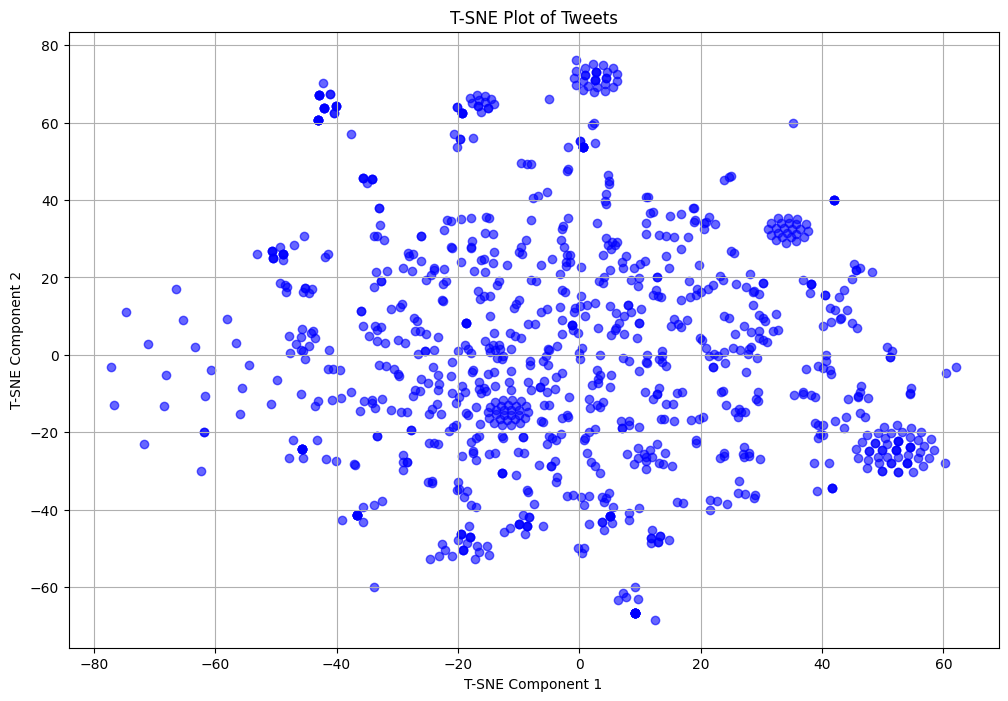

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# Extract preprocessed tweet content from the doc_tweet_map
tweet_texts = [tweet_info['Tweet'] for tweet_info in doc_tweet_map.values()]

# Step 1: Vectorize the tweets using TF-IDF
vectorizer = TfidfVectorizer(max_features=200)
tfidf_matrix = vectorizer.fit_transform(tweet_texts)

# Step 2: Convert the TF-IDF sparse matrix to a dense matrix
tfidf_array = tfidf_matrix.toarray()

# Step 3: Apply T-SNE for dimensionality reduction to 2D
tsne_model = TSNE(n_components=2, random_state=42, perplexity=20, n_iter=1000)
# We take a sample of the data as otherwise the execution is very long
sample_data = tfidf_array[:1000]
tsne_results = tsne_model.fit_transform(sample_data)

# Step 4: Visualize the T-SNE results
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6, c='blue')
plt.title('T-SNE Plot of Tweets')
plt.xlabel('T-SNE Component 1')
plt.ylabel('T-SNE Component 2')
plt.grid(True)
plt.show()